# M2177.003100 Deep Learning <br> Assignment #2 Part 2: Training Convolutional Neural Networks

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. 

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **TensorFlow**. <br>
In this notebook, you will learn how to train convolutional neural networks (CNNs) for classifying images in the CIFAR-10 dataset. <br>
There are **3 sections**, and in each section, you need to follow the instructions to complete the skeleton codes and explain them.

1. [Training a simple CNN model](#1) ( 10 points )
2. [Training a CNN model with Inception modules](#2) ( 10 points )
3. [Design a better model on CIFAR-10](#3) ( 20 points )  

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Submitting your work:
<font color=red>**DO NOT clear the final outputs**</font> so that TAs can grade both your code and results.  
Once you have done **all three parts**, run the *CollectSubmission.sh* script with your **Team number** as input argument. <br>
This will produce a compressed file called *team_#.tar.gz*. Please submit this file on ETL. &nbsp;&nbsp; (Usage example: ./*CollectSubmission.sh* &nbsp; team_77)

### Some helpful tutorials and references for assignment #2:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016. [[pdf]](https://arxiv.org/pdf/1602.07360.pdf)
- [4] Simonyan et al., "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014. [[pdf]](https://arxiv.org/pdf/1312.6034.pdf)
- [5] Szegedy et al., "Intriguing properties of neural networks", ICLR 2014. [[pdf]](https://arxiv.org/pdf/1312.6199.pdf)
- [6] Szegedy et al., "Going deeper with convolutions", CVPR 2015. [[pdf]](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)
- [7] Yosinski et al., "Understanding Neural Networks Through Deep Visualization", ICML Workshop 2015. [[pdf]](http://yosinski.com/media/papers/Yosinski__2015__ICML_DL__Understanding_Neural_Networks_Through_Deep_Visualization__.pdf)

## Load datasets
The CIFAR-10 dataset will be downloaded automatically if it is not located in the *Utils* directory. <br>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from Utils.data_utils import load_CIFAR10, plot_images
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
    
conf = tf.ConfigProto()
conf.gpu_options.per_process_gpu_memory_fraction = 0.2
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Data has already been downloaded and unpacked.
Train data shape (40000, 32, 32, 3)
Train labels shape (40000,)
Validation data shape (10000, 32, 32, 3)
Validataion labels shape (10000,)
Test data shape (10000, 32, 32, 3)
Test labels shape (10000,)


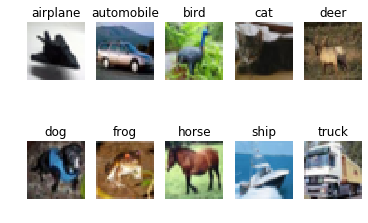

In [2]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, Class_names = load_CIFAR10()
print('Train data shape ' + str(X_train.shape))
print('Train labels shape ' + str(Y_train.shape))
print('Validation data shape ' + str(X_val.shape))
print('Validataion labels shape ' + str(Y_val.shape))
print('Test data shape ' + str(X_test.shape))
print('Test labels shape ' + str(Y_test.shape))
plot_images(X_train, Y_train, Class_names, Each_Category=True)

## <a name="1"></a> 1. Training a basic CNN model ( 10 points )

In this section, you will learn how to define a simple CNN model architecture, train the model, and evaluate its performance on the validation dataset. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow and configuring a CNN model.

Using the code provided as guidance, **(1) define**, **(2) train**, and **(3) evaluate** a model with the following architecture and training setup:

#### CNN architecture:
* 9x9 Convolutional layer with 8 filters, strides of 1, and ReLU activation
* 3x3 Max pooling layer with strides of 3
* Fully connected layer with 8 output units and ReLU activation
* Fully connected layer with 10 output units and linear activation
* You can use any padding option.

#### Training setup:
* Loss function: Sotfmax cross entropy
* Optimizer: Gradient descent with 0.01 learning rate
* Batch size: 500
* Training epoch: 1

In [3]:
# Define our model as a class
# It includes our model architecture, loss function, optimizer, and evaluation metrics
class simple_model(object):
    def __init__(self):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        self.x = tf.placeholder(tf.float32, shape=[None, *X_train.shape[1:]])
        self.y = tf.placeholder(tf.int64, shape=[None, 10])
        self.epoch = tf.Variable(0, trainable=False)
        
        def generate_conv_layers(x, padding='valid'):
            x = tf.layers.conv2d(inputs=x, filters=8, kernel_size=9, 
                                       strides=(1, 1), padding=padding)
            x = tf.nn.relu(x)
            x = tf.layers.max_pooling2d(inputs=x, pool_size=(3,3), strides=(3,3),
                                        padding=padding)
            return x
        
        x = generate_conv_layers(self.x, padding='same')
        x = generate_conv_layers(x)
        x = tf.layers.dense(inputs=x, units=8, activation=tf.nn.relu)
        x = tf.layers.dense(inputs=x, units=10, activation=None)
        self.logit = tf.squeeze(tf.squeeze(x, axis=1), axis=1)
        self.predict = tf.nn.softmax(self.logit)
        
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logit, labels=self.y)
        self.loss = tf.reduce_mean(cross_entropy)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        self.optimize = optimizer.minimize(self.loss)
        
        y_pred_cls = tf.argmax(self.predict, axis=1)
        target_cls = tf.argmax(self.y, axis=1)
        hits = tf.equal(target_cls, y_pred_cls)
        self.accuracy = tf.reduce_mean(tf.cast(hits, tf.float32))
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

# Create a function to train and evaluata a model
# You can reuse this function throughout the assignment
def run_model(session, model, X, Y, epochs=1, batch_size=500, is_training=False):
    # For training the model
    if is_training:
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        def trans_to_one_hot(data, num_of_classes):
            import numpy as np
            one_hot = np.zeros((data.shape[0], num_of_classes))
            one_hot[np.arange(data.shape[0]), data] = 1
            return one_hot
        
        def generate_random_minibatch():
            import numpy as np
            permutation = np.random.permutation(X.shape[0])[:batch_size]
            return X[permutation,:], Y[permutation]
        
        def step_by_step(data_X, data_Y, epoch, is_train=False):
            import numpy as np
            permutation = np.random.permutation(data_X.shape[0])
            
            loss = 0.0
            accuracy = 0.0
            steps = data_X.shape[0]//batch_size
            for step in range(steps):
                input_X = data_X[permutation[step*batch_size:(step+1)*batch_size],:]
                input_Y = data_Y[permutation[step*batch_size:(step+1)*batch_size]]
                feed_dict = {
                    model.x: input_X,
                    model.y: trans_to_one_hot(input_Y, 10),
                    model.epoch : epoch,
                }
                if is_train:
                    _, loss_, accuracy_ = session.run([model.optimize, model.loss, model.accuracy], feed_dict=feed_dict)
                else:
                    loss_, accuracy_ = session.run([model.loss, model.accuracy], feed_dict=feed_dict)
                loss += loss_
                accuracy += accuracy_
            
            return loss / data_X.shape[0] * batch_size, accuracy / data_X.shape[0] * batch_size
        
        for epoch in range(epochs):
            train_loss, train_acc = step_by_step(X, Y, epoch, is_train=True)
            if epoch % 10 == 0:
                val_loss, val_acc = step_by_step(X_val, Y_val, epoch, is_train=False)
                print('epoch %d : train_loss(%.4f) train_acc(%.4f) val_loss(%.4f) val_acc(%.4f)' % (epoch, train_loss, train_acc, val_loss, val_acc))
                
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        print("Training done!")

    # Evaluate loss and accuracy of the model
    else:
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        def trans_to_one_hot(data, num_of_classes):
            import numpy as np
            one_hot = np.zeros((data.shape[0], num_of_classes))
            one_hot[np.arange(data.shape[0]), data] = 1
            return one_hot
        
        loss = 0.0
        accuracy = 0.0
        for step in range(X.shape[0]//batch_size):
            input_X = X[batch_size*step:batch_size*(step+1)]
            input_Y = Y[batch_size*step:batch_size*(step+1)]
            feed_dict_train = {
                model.x: input_X,
                model.y: trans_to_one_hot(input_Y, 10),
            }
            loss_, accuracy_ = session.run([model.loss, model.accuracy], feed_dict=feed_dict_train)
            loss += loss_
            accuracy += accuracy_
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
        return (loss / X.shape[0] * batch_size, accuracy / X.shape[0] * batch_size)

# Clear old variables
tf.reset_default_graph()    

# Declare out simple model
model = simple_model()
    
# Now, train and evaluate the model
with tf.Session(config=conf) as sess:
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    sess.run(tf.global_variables_initializer())
    run_model(sess, model, X_train, Y_train, epochs=1, batch_size=500, is_training=True)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    print("(Loss, Accuracy) on Training Dataset (%.4f, %.2f)" % run_model(sess, model, X_train, Y_train))
    print("(Loss, Accuracy) on Validataion Dataset (%.4f, %.2f)" % run_model(sess, model, X_val, Y_val))

epoch 0 : train_loss(2.2950) train_acc(0.1375) val_loss(2.2628) val_acc(0.1545)
Training done!
(Loss, Accuracy) on Training Dataset (2.2625, 0.16)
(Loss, Accuracy) on Validataion Dataset (2.2628, 0.15)


## <a name="2"></a>2. Training a CNN model with Inception module ( 10 points )

In this section, you will implement a little more complex CNN model with an `Inception module` [6]. <br>

![Inception_module](Utils/InceptionModule_GoogLeNet.png)

Using the code provided as guidance, <br>
**(1)** Define an `inception module`, which is the building block of **Inception model (a.k.a GoogLeNet)**, the winner of ILSVRC14. <br>
**(2)** Define, train, and evaluate a CNN model with the following architecture and training setup:

#### CNN architecture:
* `Inception module` with 
    * 8 filters for the main convolutions (blue blocks in the Figure(a))
    * 2 filters for the dimensionality reduction convolutions (yellow blocks in the Figure(a))
    *  ReLU activation
* Fully connected layer with 10 output units and linear activation
* Choose the proper padding option on your own.

#### Training setup:
* Loss function: Sotfmax cross entropy
* Optimizer: Gradient descent with 0.01 learning rate
* Batch size: 500
* Training epoch: 5

In [4]:
def Inception_module(Input, C1, C3_R, C3, C5_R, C5, P3_R):
    '''
    C1, C3, C5: number of filters for the main convolutions
    C3_R, C5_R, P3_R: number of filters for the dimensionality reduction convolutions
    '''
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    b1 = tf.layers.conv2d(inputs=Input, filters=C1, kernel_size=1, 
                                strides=(1, 1), padding='same')
    
    b2 = tf.layers.conv2d(inputs=Input, filters=C3_R, kernel_size=1, 
                                strides=(1, 1), padding='same')
    b2 = tf.layers.conv2d(inputs=b2, filters=C3, kernel_size=3, 
                                strides=(1, 1), padding='same')
    
    b3 = tf.layers.conv2d(inputs=Input, filters=C5_R, kernel_size=1, 
                                strides=(1, 1), padding='same')
    b3 = tf.layers.conv2d(inputs=b3, filters=C5, kernel_size=5, 
                                strides=(1, 1), padding='same')
    
    b4 = tf.layers.max_pooling2d(inputs=Input, pool_size=(3,3),
                                 strides=(1, 1), padding='same')
    b4 = tf.layers.conv2d(inputs=b4, filters=P3_R, kernel_size=1, 
                                strides=(1, 1), padding='same')
    
    Inception = tf.nn.relu(tf.concat([b1,b2,b3,b4], axis=3))
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return Inception

class complex_model(object):
    def __init__(self):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        self.x = tf.placeholder(tf.float32, shape=[None, *X_train.shape[1:]])
        self.y = tf.placeholder(tf.int64, shape=[None, 10])
        self.epoch = tf.Variable(0, trainable=False)
        
        # ?, 32, 32, 3
        x = tf.layers.conv2d(inputs=self.x, filters=16, kernel_size=7, 
                                       strides=(1, 1), padding='same')
        # ?, 32, 32, 16
        x = tf.layers.max_pooling2d(inputs=x, pool_size=(3,3), strides=(2,2),
                                        padding='same')
        # ?, 16, 16, 16
        x = Inception_module(x, 4, 8, 16, 4, 16, 16)
        # ?, 16, 16, 52
        x = tf.layers.max_pooling2d(inputs=x, pool_size=(3,3), strides=(2,2),
                                        padding='same')
        # ?, 8, 8, 52
        x = Inception_module(x, 4, 8, 16, 4, 16, 16)
        # ?, 8, 8, 52
        x = tf.layers.max_pooling2d(inputs=x, pool_size=(8,8), strides=(2,2),
                                        padding='valid')
        # ?, 1, 1, 52
        
        x = tf.layers.dense(inputs=x, units=32, activation=tf.nn.relu)
        x = tf.layers.dense(inputs=x, units=10, activation=tf.nn.relu)
        self.logit = tf.squeeze(tf.squeeze(x, axis=1), axis=1)
        self.predict = tf.nn.softmax(self.logit)
        
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logit, labels=self.y)
        self.loss = tf.reduce_mean(cross_entropy)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        self.optimize = optimizer.minimize(self.loss)
        
        y_pred_cls = tf.argmax(self.predict, axis=1)
        target_cls = tf.argmax(self.y, axis=1)
        hits = tf.equal(target_cls, y_pred_cls)
        self.accuracy = tf.reduce_mean(tf.cast(hits, tf.float32))
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ############################################################################## 

# Clear old variables
tf.reset_default_graph()

# Declare out simple model
model = complex_model()    
    
# Now, create a tf.Session and train the model
with tf.Session(config=conf) as sess:
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    sess.run(tf.global_variables_initializer())
    run_model(sess, model, X_train, Y_train, epochs=5, batch_size=500, is_training=True)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    print("(Loss, Accuracy) on Training Dataset (%.4f, %.2f)" % run_model(sess, model, X_train, Y_train))
    print("(Loss, Accuracy) on Validataion Dataset (%.4f, %.2f)" % run_model(sess, model, X_val, Y_val))

epoch 0 : train_loss(2.2791) train_acc(0.1445) val_loss(2.2527) val_acc(0.1806)
Training done!
(Loss, Accuracy) on Training Dataset (2.0036, 0.30)
(Loss, Accuracy) on Validataion Dataset (1.9991, 0.30)


## <a name="3"></a>3. Design a better model on CIFAR-10 ( 20 points )

Now it's your job to experiment with CNNs to train a model that achieves **<font color=red>>= 70% accuracy on the validation set</font>** of CIFAR-10. <br> You can reuse the implemented functions from above.

### Things you can try to change:
- Filter size
- Number of filters
- Pooling vs Strided Convolution
- Network architectures
- Optimizers
- Activation functions
- Regularizations
- Model ensembles
- Data augmentation

In [5]:
class my_model(object):
    def __init__(self):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        self.x = tf.placeholder(tf.float32, shape=[None, *X_train.shape[1:]])
        self.y = tf.placeholder(tf.int64, shape=[None, 10])
        self.epoch = tf.Variable(0, trainable=False)
        
        # ?, 32, 32, 3
        x = tf.layers.conv2d(inputs=self.x, filters=48, kernel_size=3, 
                                       strides=(1, 1), padding='same')
        x = tf.nn.relu(tf.layers.batch_normalization(x, training=True))
        x = tf.layers.max_pooling2d(inputs=x, pool_size=(3,3), strides=(2,2),
                                        padding='same')
        x = tf.layers.conv2d(inputs=x, filters=64, kernel_size=3, 
                                       strides=(1, 1), padding='same')
        x = tf.nn.relu(tf.layers.batch_normalization(x, training=True))
        x = tf.layers.max_pooling2d(inputs=x, pool_size=(3,3), strides=(2,2),
                                        padding='same')
        #x = Inception_module(x, 4, 8, 12, 4, 8, 4) # 28
        #x = Inception_module(x, 4, 4, 16, 4, 8, 8) # 36
        #x = Inception_module(x, 4, 8, 16, 8, 16, 8) # 44
        #x = Inception_module(x, 8, 8, 24, 8, 16, 8) # 56
        #x = Inception_module(x, 8, 16, 24, 8, 16, 12) # 60
        #x = Inception_module(x, 8, 16, 32, 8, 16, 16) # 72
        #x = Inception_module(x, 16, 24, 32, 16, 24, 16) # 88
        #x = Inception_module(x, 24, 24, 48, 24, 32, 24) # 128
        #x = Inception_module(x, 24, 24, 52, 16, 48, 32) # 156

        # Inception 1
        x = Inception_module(x, 8, 16, 32, 8, 16, 16) # 72
        
        x = tf.layers.max_pooling2d(inputs=x, pool_size=(3,3), strides=(2,2),
                                        padding='same')
        #  Inception 2
        x = Inception_module(x, 8, 16, 32, 8, 16, 16) # 72
        x = Inception_module(x, 16, 24, 32, 16, 24, 16) # 88
        
        x = tf.layers.max_pooling2d(inputs=x, pool_size=(3,3), strides=(2,2),
                                        padding='same')
        #  Inception 3
        x = Inception_module(x, 24, 24, 48, 24, 32, 24) # 128
        
        
        x = tf.layers.average_pooling2d(inputs=x, pool_size=(2,2), strides=(1,1),
                                        padding='valid')
        x = tf.squeeze(tf.squeeze(x, axis=1), axis=1)
        x = tf.layers.dropout(x, rate=0.5)
        
        x = tf.layers.dense(inputs=x, units=96, activation=tf.nn.relu)
        x = tf.layers.dense(inputs=x, units=10, activation=None)
        
        self.logit = x
        self.predict = tf.nn.softmax(self.logit)
        
        rate = tf.train.exponential_decay(0.001, self.epoch, 50, 0.95)
        
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logit, labels=self.y)
        self.loss = tf.reduce_mean(cross_entropy)
        self.optimize = tf.train.AdamOptimizer(learning_rate=rate).minimize(self.loss)
        
        y_pred_cls = tf.argmax(self.predict, axis=1)
        target_cls = tf.argmax(self.y, axis=1)
        hits = tf.equal(target_cls, y_pred_cls)
        self.accuracy = tf.reduce_mean(tf.cast(hits, tf.float32))
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

# Clear old variables
tf.reset_default_graph()    

# Declare out simple model
model = my_model()

# Now, create a tf.Session and train the model
with tf.Session(config=conf) as sess:
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    sess.run(tf.global_variables_initializer())
    run_model(sess, model, X_train, Y_train, epochs=50, batch_size=2000, is_training=True)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    print("(Loss, Accuracy) on Training Dataset (%.4f, %.2f)" % run_model(sess, model, X_train, Y_train))
    print("(Loss, Accuracy) on Validataion Dataset (%.4f, %.2f)" % run_model(sess, model, X_val, Y_val))
    
    #Save your final model
    saver = tf.train.Saver()
    saver.save(sess, "./Utils/model_checkpoints/my_model_final")

epoch 0 : train_loss(2.0234) train_acc(0.2472) val_loss(1.6971) val_acc(0.3573)
epoch 10 : train_loss(0.8429) train_acc(0.7003) val_loss(0.9282) val_acc(0.6729)
epoch 20 : train_loss(0.6394) train_acc(0.7723) val_loss(0.8211) val_acc(0.7175)
epoch 30 : train_loss(0.4743) train_acc(0.8354) val_loss(0.8175) val_acc(0.7334)
epoch 40 : train_loss(0.3467) train_acc(0.8812) val_loss(0.8677) val_acc(0.7394)
Training done!
(Loss, Accuracy) on Training Dataset (0.2465, 0.92)
(Loss, Accuracy) on Validataion Dataset (0.9776, 0.74)


### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

#### To extract features from the training set
* make layer structure similar with the original paper.
<p>We add convolutional layes at the beginning to increase the channel. Then, uses multiple inception layers to capture features of image and maxpooling to decrease feature dimension. Last, we decrease channel using multiple dense layers with batch normalization and relu activation.</p>
* deeper stacked inception layers.
<p>We stacked multiple inception layers to capture not only low level features but also high level. This may increas parameters to be learned. But compare with the simple model, it keeps decrease train loss which means that there are many features in the dataset which is essential to make a correct classification.</p>

#### To train efficiently
* change optimizer to Adam
<p>Comparing with SGD optimizer, Adam made huge improvement on the accuracy of model.</p>
* exponetially decay the learning rate
<p>We found that when we keep increase epoch, train loss oscillate and even keep increase after some epoch. After we add decay term in our model, train loss of model keep decrease even it is just small amount.</p>
* generate random batch for the every step
<p>To avoid biased learning, we permutate indices of input to make random subset of them for each train step.</p>
* increase batch size to 2000
<p>To increase learning efficiency on the multiprocessing enviroment, we increase batch_size to 2000. This will help the performance of batch normalization layer also.</p>
* adds batch normalization layers
We add batch normalization layer after the dense layer to normalize activations to increase train efficiency.

#### To prevent overfitting
* adds a dropout layer
We add parameters of model until our gpu memory give OOM error. To prevent overfitting, we add dropout layer just before the dense layer.



### Test Set - Do this only once
Now that you've gotten a result that you're happy with, test your final model on the test set. This would be the score you would achieve on a competition. Think about how this compares to your validation set accuracy.

In [6]:
# Clear old variables
tf.reset_default_graph()  

with tf.Session(config=conf) as sess:
    #Load your final model
    model = my_model()
    saver = tf.train.Saver()
    saver.restore(sess, "./Utils/model_checkpoints/my_model_final")
    print("(Loss, Accuracy) on Test Dataset (%.4f, %.2f)" % run_model(sess, model, X_test, Y_test))

INFO:tensorflow:Restoring parameters from ./Utils/model_checkpoints/my_model_final
(Loss, Accuracy) on Test Dataset (0.9862, 0.73)
